In [1]:
from shapely.geometry import Polygon,Point
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from shapes import *
import numpy as np

In [2]:
# class Domain2D():
#     def __init__(self,base :Polygon ) -> None:
#         self.operations ={'base_op_1':base}
#         self.num_operations = 1 
#         self.Domain = base
#         self.bounds = self.Domain.bounds
#         self.contains = self.Domain.contains

#     def __getitem__(self,key):
#         #Returns the coords of a part of the domain
#         return self.operations[key]
    
#     def merge(self,*shapes,names = None):
#         self.boolean_op(*shapes,names = names,op = 'add',inplace=True)
#     def remove(self,*shapes,names= None):
#         self.boolean_op(*shapes,names=names,op = 'sub',inplace=True)

#     def boolean_op(self,*shapes,names=None,op = None,inplace = False):
#         '''
#         Operation to merge or remove shapes from existing combined into one as only difference is whether union or difference is called
#         '''

#         if op == 'add':
#             oper = 'union'
#         elif op == 'sub':
#             oper = 'difference'

#         if names is not None:
#             assert len(shapes) == len(names)
        
#         looper = shapes if names is None else zip(shapes,names)

#         for val in looper:
#             if names is None:
#                 shape = val                
#             else:
#                 shape,ID = val
            
#             print(shape)
#             if isinstance(shape,Domain2D):
#                 shape = shape.Domain

#             self.Domain = getattr(self.Domain,oper)(shape)
#             #Update bounds
#             self.bounds = self.Domain.bounds
#             self.contains = self.Domain.contains
            
#             self.num_operations += 1
            
#             if names is None:
#                 ID = f'{op}_{str(shape.geom_type)}_op_{self.num_operations}'  
#             self.operations[ID] = shape
        
#         if not inplace:
#             return self
    
#     def create_boundary_group(self,shapeID,name):
#         self.operations[name] = self.operations[shapeID].exterior

    
#     def generate_points(self,n,func = None,**kwargs):
#         '''
#         sample points from domain. Default triangulates the domain and then samples from the
#             triangulated domain
        
#         Users can implement their own custom function by passing it in with func. func 
#         should take the form f(n,shape,kw1,kw2...) where n is the number of points to 
#         sample, shape is some Polygon object followed by any other keyword arguements

#         '''
#         shape = shape.Domain
#         if func is None:
#             points,triangles = triangulate_shape(shape,**kwargs)
#             return generate_points_from_triangles(points,triangles,n)
#         else:
#             return func(n,shape,**kwargs)

        
        

        

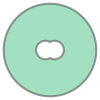

In [21]:
num_points = 100
a = Circle((0,0),r =5,num_points = num_points)
b = Circle((-0.5,0),r =1,num_points = num_points)
c = Circle((0.5,0),r =1,num_points = num_points)


# f = Circle((2,1),r =1)


d = Domain2D(base = a)
e = Domain2D(base = b) 
e.merge(c)

d.remove(e,names = ['hole'])
d.Domain

d.create_boundary_group('hole','wall-1')
d.Domain



In [3]:
rectangle_coords = [(0, 0), (0, 4), (4, 4), (4, 0)]

# Create the outer rectangle as a polygon
rectangle = Polygon(rectangle_coords)


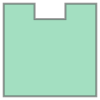

In [4]:
a = Rectangle(((0,0),3,3),'midpoint')
b = Rectangle(((0,1.5),1,1),'midpoint')

c = Domain2D(base = a)
c.remove(b,names = ['hole'])
c.Domain

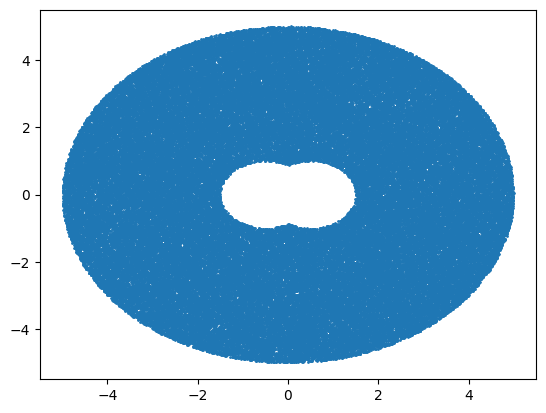

In [27]:
sampled_points = d.generate_points(100000)

plt.scatter(sampled_points[:,0],sampled_points[:,1],s=1)
# triangulate_shape(d.Domain,show_plot=True)

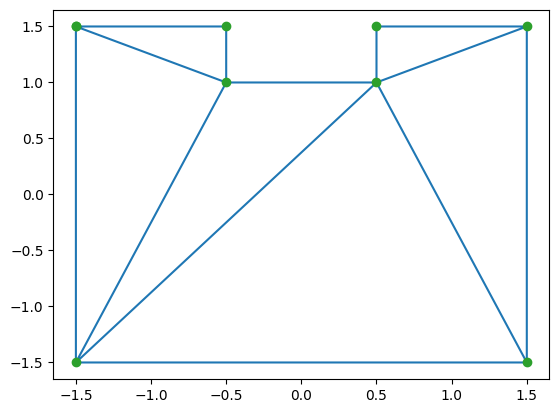

POLYGON ((-0.5 1, -0.5 1.5, -1.5 1.5, -0.5 1))
POLYGON ((0.5 1, 1.5 -1.5, 1.5 1.5, 0.5 1))
POLYGON ((0.5 1.5, 0.5 1, 1.5 1.5, 0.5 1.5))
POLYGON ((0.5 1, -1.5 -1.5, 1.5 -1.5, 0.5 1))
POLYGON ((-1.5 -1.5, 0.5 1, -0.5 1, -1.5 -1.5))


8.5

In [25]:
points,t2 = triangulate_shape(c,show_plot=True)

p = points[t2[0]]
f = Domain2D(base = Polygon(p))
for tri_points in t2[1:]:
    p = points[tri_points]
    f.merge(Polygon(p))
f.Domain
f.Domain.area

In [67]:
#Unoptimised Code
probs = triangle_proportion(points,t2)

def sample_triangles(triangles,n,probs):    
    indices = np.arange(len(triangles))
    return np.random.choice(indices,size = n, p = probs)

def gen_point_in_triangle(points,triangle,U1,U2):
    coords = points[triangle]
    a =  coords[1]-coords[0]
    b =  coords[2]-coords[0]
    w = U1*a + U2*b
    return w + coords[0]

n = 100_000_000
tri_idxs = sample_triangles(t2,n=n,probs = probs)
U = np.random.rand(n,2)
U[U[:,0] + U[:,1] > 1 ] = 1-U[U[:,0] + U[:,1] > 1]

# for idx,(u1,u2) in zip(tri_idxs,U):
#     gen_point_in_triangle(points,t2[idx],u1,u2)

sampled_points = np.array([gen_point_in_triangle(points,t2[idx],u1,u2) for idx,(u1,u2) in zip(tri_idxs,U)])


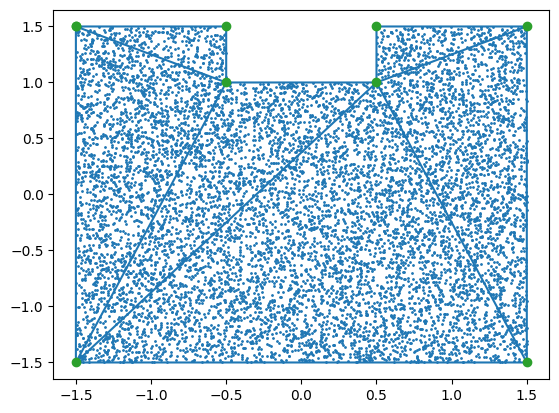

In [39]:
plt.scatter(sampled_points[:,0],sampled_points[:,1],s=1)
points,t2 = triangulate_shape(c,show_plot=True)

In [30]:
U[U[:,0] + U[:,1] > 1 ] = 1-U[U[:,0] + U[:,1] > 1]

In [75]:

def sample_from_triangles(points,triangles,n):
    '''
    Given a list of triangles and the coordinates of each vertex that comprise a Domain/polygon shape sample n points

    Reflection step and sampling from triangles is explained by a great blog post by Rick Wicklin:
    https://blogs.sas.com/content/iml/2020/10/19/random-points-in-triangle.html  

    This is a much more optimised method of generating points using numpy to do a lot of the heavy lifting (i.e. everything is done in C)
    '''

    #Get probabilities of each triangle (based on area) and then sample from the distribution n times
    probs = triangle_proportion(points,triangles)
    indices = sample_triangles(triangles,n,probs)
    
    # Creates an nx3x2 array of points - 2nd axis repr the 3 points of the ith sampled triangle and 3rd axis is coords of this sampled triangle (x,y)
    coords = points[triangles[indices]]

    #Generate points on unit square.
    U = np.random.rand(n,2)
    #Reflection of points of unit square see link for explanation
    U[U[:,0] + U[:,1] > 1 ] = 1-U[U[:,0] + U[:,1] > 1]
    
    #Create a and b vectors:
    a = coords[:,1,:] - coords[:,0,:]
    b = coords[:,2,:] - coords[:,0,:]

    #Generate point in each triangle
    p = a*(U[:,0])[:,np.newaxis] + b*(U[:,1])[:,np.newaxis]+ coords[:,0,:]
    return p 

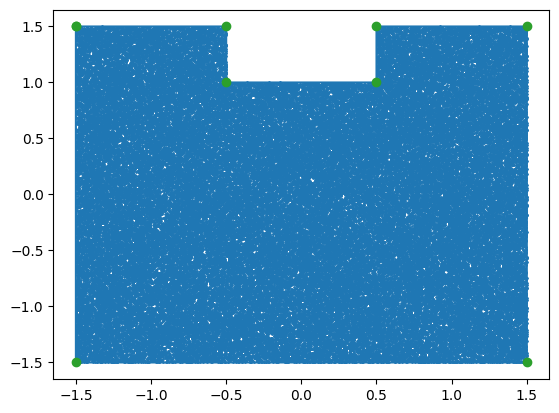

In [77]:
sampled_points = Generate_Points(points,t2,n=100_000)

plt.scatter(sampled_points[:,0],sampled_points[:,1],s=1)
points,t2 = triangulate_shape(c,show_plot=True)